In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
# from kerastuner.tuners import RandomSearch
import pandas as pd
import networkx as nx
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import InceptionV3
import matplotlib.image as mpimg

In [31]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"tariqh8","key":"0d60c2775cf0a44b574e16a99ad041e8"}'}

In [32]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
!kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

tom-and-jerry-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
!unzip -q tom-and-jerry-image-classification.zip -d ./tom-and-jerry-image-classification
print("Unzipped")

Unzipped


In [35]:
IMAGE_DIRECTORY = "./tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/"

batch_size = 64
#batch_size is the number of training examples utilized in one iteration. It affects the speed and performance of your training process.
img_height = 224
img_width = 224

In [36]:
full_train_ds = image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train_ds = full_train_ds.take(700 // batch_size)


Found 5478 files belonging to 4 classes.
Using 4383 files for training.


In [37]:
full_val_ds = image_dataset_from_directory(
  IMAGE_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = full_val_ds.take(700 // batch_size)


Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


In [38]:
class_names = full_train_ds.class_names
print(class_names)

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(700).prefetch(buffer_size=AUTOTUNE)
# shuffle for randomness
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        #perspective
        layers.RandomRotation(0.1),
        #scale
        layers.RandomZoom(0.2),
    ]
)

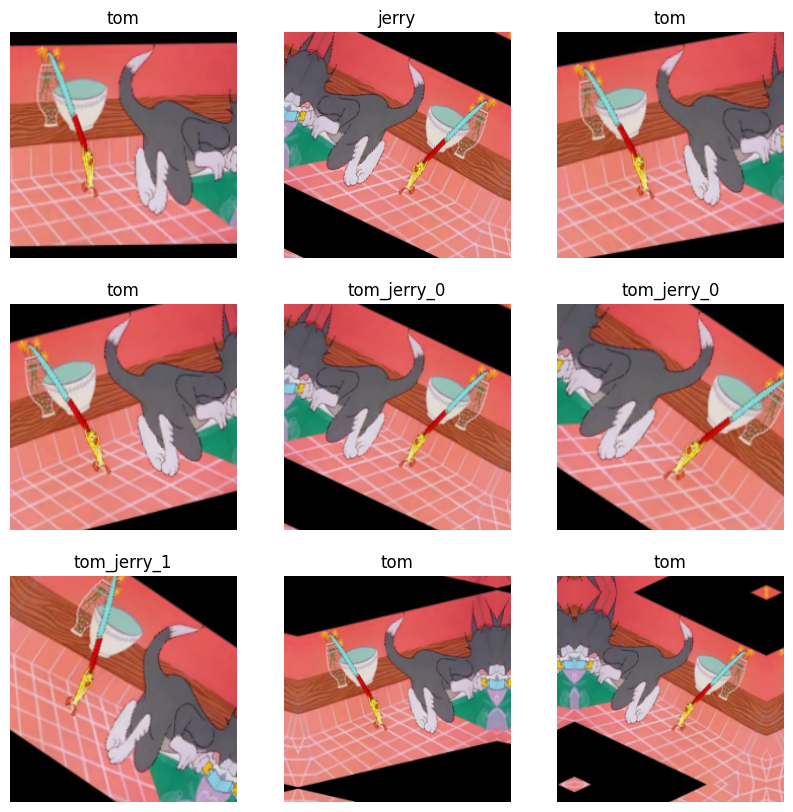

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [58]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [43]:
num_classes = len(class_names)
#input an rgb image
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
#range of 0,1
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#filters
#detect featuures
#weights
#filters, grid, input size, - to 0
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
#max value, reduce data
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
#one dimension
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(num_classes)(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                     

In [46]:
epochs = 30

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/30
10/10 [==============================] - 6s 380ms/step - loss: 1.3992 - accuracy: 0.3125 - val_loss: 1.3416 - val_accuracy: 0.3641
Epoch 2/30
10/10 [==============================] - 1s 92ms/step - loss: 1.3427 - accuracy: 0.3562 - val_loss: 1.3385 - val_accuracy: 0.3641
Epoch 3/30
10/10 [==============================] - 1s 85ms/step - loss: 1.3231 - accuracy: 0.3562 - val_loss: 1.3016 - val_accuracy: 0.3625
Epoch 4/30
10/10 [==============================] - 1s 85ms/step - loss: 1.3007 - accuracy: 0.3719 - val_loss: 1.2930 - val_accuracy: 0.3781
Epoch 5/30
10/10 [==============================] - 1s 89ms/step - loss: 1.2717 - accuracy: 0.3781 - val_loss: 1.2359 - val_accuracy: 0.3969
Epoch 6/30
10/10 [==============================] - 1s 91ms/step - loss: 1.2193 - accuracy: 0.4219 - val_loss: 1.2044 - val_accuracy: 0.4266
Epoch 7/30
10/10 [==============================] - 1s 88ms/step - loss: 1.1609 - accuracy: 0.4484 - val_loss: 1.1908 - val_accuracy: 0.4641
Epoch 8/30
1

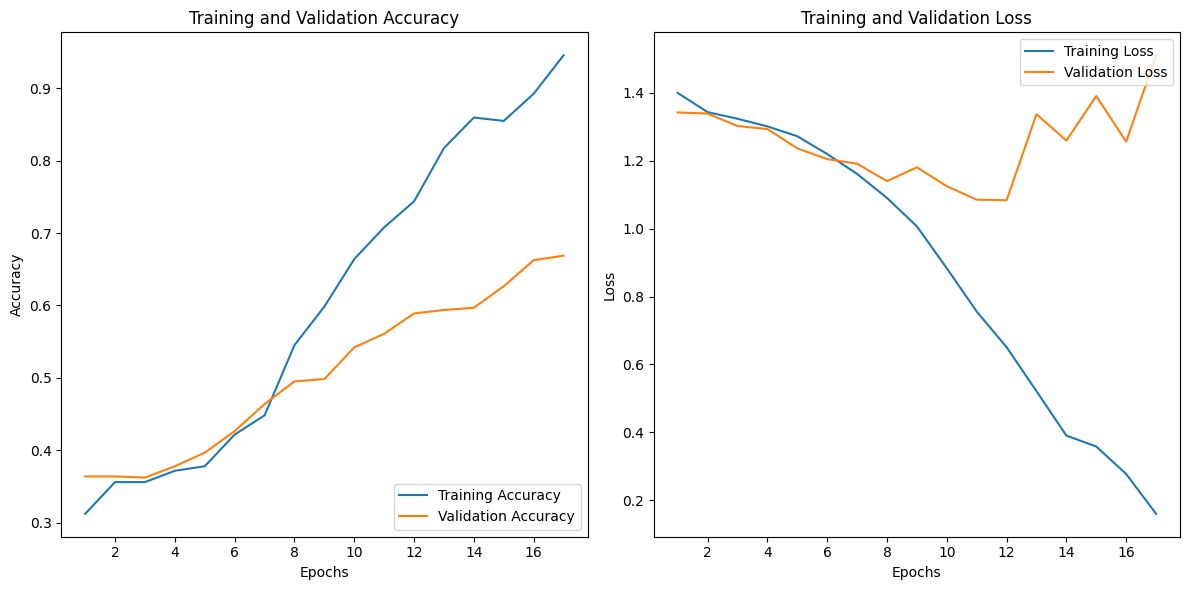

In [47]:
stopped_epoch = early_stopping.stopped_epoch

acc = history.history['accuracy'][:stopped_epoch + 1]
val_acc = history.history['val_accuracy'][:stopped_epoch + 1]
loss = history.history['loss'][:stopped_epoch + 1]
val_loss = history.history['val_loss'][:stopped_epoch + 1]

epochs_range = range(1, stopped_epoch + 2)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [48]:
# data_dir = "./tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/"
image_size = (224, 224)

In [49]:
data = []
labels = []

subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

for label, class_names in enumerate(class_names):
    folder_path = os.path.join(IMAGE_DIRECTORY, class_names)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        data.append(os.path.join(class_names, image_file))
        labels.append(label)


df = pd.DataFrame({'image_file': data, 'label': labels})

In [50]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [51]:
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_model()

In [52]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
batch_size = 64
epochs = 10

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=IMAGE_DIRECTORY,
    x_col='image_file',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=IMAGE_DIRECTORY,
    x_col='image_file',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)


Found 3943 validated image filenames.
Found 439 validated image filenames.
Epoch 1/10
62/62 [==============================] - 105s 1s/step - loss: 0.9646 - accuracy: 0.6046 - val_loss: 6.1787 - val_accuracy: 0.3349
Epoch 2/10
62/62 [==============================] - 71s 1s/step - loss: 0.4490 - accuracy: 0.8483 - val_loss: 1.4247 - val_accuracy: 0.5991
Epoch 3/10
62/62 [==============================] - 71s 1s/step - loss: 0.3075 - accuracy: 0.9062 - val_loss: 0.8623 - val_accuracy: 0.6697
Epoch 4/10
62/62 [==============================] - 74s 1s/step - loss: 0.2399 - accuracy: 0.9216 - val_loss: 1.6399 - val_accuracy: 0.5763
Epoch 5/10
62/62 [==============================] - 72s 1s/step - loss: 0.2041 - accuracy: 0.9353 - val_loss: 0.4499 - val_accuracy: 0.8702
Epoch 6/10
62/62 [==============================] - 73s 1s/step - loss: 0.1839 - accuracy: 0.9399 - val_loss: 1.5199 - val_accuracy: 0.6583
Epoch 7/10
62/62 [==============================] - 72s 1s/step - loss: 0.1692 - acc

In [54]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

7/7 [==============================] - 2s 277ms/step - loss: 0.5336 - accuracy: 0.8155
Validation loss: 0.533608615398407, Validation accuracy: 0.8154897689819336


In [55]:
for layer in model.layers:
    layer.trainable = True

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


fine_tune_epochs = 10

history_fine_tune = model.fit(train_generator,
                             epochs=epochs + fine_tune_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=val_generator)

Epoch 10/20
62/62 [==============================] - 107s 1s/step - loss: 0.0767 - accuracy: 0.9767 - val_loss: 0.1636 - val_accuracy: 0.9590
Epoch 11/20
62/62 [==============================] - 73s 1s/step - loss: 0.0523 - accuracy: 0.9828 - val_loss: 0.1579 - val_accuracy: 0.9636
Epoch 12/20
62/62 [==============================] - 72s 1s/step - loss: 0.0423 - accuracy: 0.9855 - val_loss: 0.1375 - val_accuracy: 0.9613
Epoch 13/20
62/62 [==============================] - 71s 1s/step - loss: 0.0355 - accuracy: 0.9871 - val_loss: 0.1602 - val_accuracy: 0.9636
Epoch 14/20
62/62 [==============================] - 75s 1s/step - loss: 0.0281 - accuracy: 0.9891 - val_loss: 0.1449 - val_accuracy: 0.9613
Epoch 15/20
62/62 [==============================] - 75s 1s/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.1474 - val_accuracy: 0.9613
Epoch 16/20
62/62 [==============================] - 76s 1s/step - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.1399 - val_accuracy: 0.9658
Epoch 17/20


In [57]:
val_loss_fine_tune, val_accuracy_fine_tune = model.evaluate(val_generator)
print(f'Validation loss (fine-tuned): {val_loss_fine_tune}, Validation accuracy (fine-tuned): {val_accuracy_fine_tune}')

7/7 [==============================] - 3s 360ms/step - loss: 0.1767 - accuracy: 0.9522
Validation loss (fine-tuned): 0.17667505145072937, Validation accuracy (fine-tuned): 0.9521639943122864
